In [12]:
import os
print(os.listdir())

['.config', 'drive', 'sample_data']


In [13]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/masked_dataset_fer.csv')

In [14]:
display(df.head())
df.info()
display(df.describe())
display(df.isnull().sum())

,file name,image pixel,age,gender,emotion,split
0,0-with-mask.jpg,76 78 78 71 61 56 57 61 60 60 54 56 84 119 127...,29,Man,angry,train
1,1-with-mask.jpg,151 151 150 153 145 122 119 141 170 179 176 16...,27,Man,angry,train
2,10-with-mask.jpg,29 28 18 15 24 32 44 63 87 100 115 126 134 139...,27,Man,angry,train
3,10002-with-mask.jpg,32 20 18 53 47 40 29 48 95 105 20 16 39 10 31 ...,34,Man,angry,train
4,10016-with-mask.jpg,226 219 200 189 204 214 181 133 105 93 39 39 5...,34,Woman,angry,train


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20484 entries, 0 to 20483
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   file name    20484 non-null  object
 1   image pixel  20484 non-null  object
 2   age          20484 non-null  int64 
 3   gender       20484 non-null  object
 4   emotion      20484 non-null  object
 5   split        20484 non-null  object
dtypes: int64(1), object(5)
memory usage: 960.3+ KB


,age
count,20484.000000
mean,28.607059
std,4.807053
min,16.000000
25%,25.000000
50%,28.000000
75%,32.000000
max,50.000000


,0
file name,0
image pixel,0
age,0
gender,0
emotion,0
split,0


In [15]:
import numpy as np

# Convert pixel strings to numpy arrays
df['image_pixels_array'] = df['image pixel'].apply(lambda x: np.array(x.split(), dtype=np.float32))

# Reshape pixel arrays to 48x48 and normalize
df['processed_image'] = df['image_pixels_array'].apply(lambda x: x.reshape(48, 48) / 255.0)

# Drop the original 'image pixel' and the intermediate 'image_pixels_array' columns to save memory
df = df.drop(columns=['image pixel', 'image_pixels_array'])

display(df.head())

,file name,age,gender,emotion,split,processed_image
0,0-with-mask.jpg,29,Man,angry,train,"[[0.29803923, 0.30588236, 0.30588236, 0.278431..."
1,1-with-mask.jpg,27,Man,angry,train,"[[0.5921569, 0.5921569, 0.5882353, 0.6, 0.5686..."
2,10-with-mask.jpg,27,Man,angry,train,"[[0.11372549, 0.10980392, 0.07058824, 0.058823..."
3,10002-with-mask.jpg,34,Man,angry,train,"[[0.1254902, 0.078431375, 0.07058824, 0.207843..."
4,10016-with-mask.jpg,34,Woman,angry,train,"[[0.8862745, 0.85882354, 0.78431374, 0.7411765..."


In [17]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Separate dataframes based on the 'split' column, only using train and validation
train_df = df[df['split'] == 'train'].copy()
validation_df = df[df['split'] == 'validation'].copy()

# Extract image data and labels
X_train = np.stack(train_df['processed_image'].values)
y_train = train_df['emotion'].values

X_val = np.stack(validation_df['processed_image'].values)
y_val = validation_df['emotion'].values

# Add channel dimension for grayscale images
X_train = np.expand_dims(X_train, -1)
X_val = np.expand_dims(X_val, -1)

# Encode emotion labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# One-hot encode the labels
y_train_one_hot = to_categorical(y_train_encoded)
y_val_one_hot = to_categorical(y_val_encoded)

print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train_one_hot.shape)
print("Validation data shape:", X_val.shape)
print("Validation labels shape:", y_val_one_hot.shape)
print("Number of emotion classes:", len(label_encoder.classes_))

Training data shape: (15531, 48, 48, 1)
Training labels shape: (15531, 7)
Validation data shape: (4953, 48, 48, 1)
Validation labels shape: (4953, 7)
Number of emotion classes: 7


In [18]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import numpy as np

# Encode gender
gender_encoder = LabelEncoder()
train_df['gender_encoded'] = gender_encoder.fit_transform(train_df['gender'])
validation_df['gender_encoded'] = gender_encoder.transform(validation_df['gender'])

# Encode age
age_encoder = LabelEncoder()
train_df['age_encoded'] = age_encoder.fit_transform(train_df['age'])
validation_df['age_encoded'] = age_encoder.transform(validation_df['age'])


# One-hot encode gender
train_df['gender_one_hot'] = train_df['gender_encoded'].apply(lambda x: to_categorical(x, num_classes=len(gender_encoder.classes_)))
validation_df['gender_one_hot'] = validation_df['gender_encoded'].apply(lambda x: to_categorical(x, num_classes=len(gender_encoder.classes_)))


# One-hot encode age
train_df['age_one_hot'] = train_df['age_encoded'].apply(lambda x: to_categorical(x, num_classes=len(age_encoder.classes_)))
validation_df['age_one_hot'] = validation_df['age_encoded'].apply(lambda x: to_categorical(x, num_classes=len(age_encoder.classes_)))


# Print shapes
print("Training gender one-hot shape:", np.stack(train_df['gender_one_hot'].values).shape)
print("Validation gender one-hot shape:", np.stack(validation_df['gender_one_hot'].values).shape)
print("Training age one-hot shape:", np.stack(train_df['age_one_hot'].values).shape)
print("Validation age one-hot shape:", np.stack(validation_df['age_one_hot'].values).shape)

Training gender one-hot shape: (15531, 2)
Validation gender one-hot shape: (4953, 2)
Training age one-hot shape: (15531, 32)
Validation age one-hot shape: (4953, 32)


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Get the number of emotion classes from the processed labels
num_classes = y_train_one_hot.shape[1]

# Instantiate a Sequential model
model = Sequential()

# Add convolutional and pooling layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the output
model.add(Flatten())

# Add dense layers
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 355,847 (1.36 MB)

 Trainable params: 355,847 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model

# Define the input shape
input_shape = (48, 48, 1)

# Define the input layer
input_tensor = Input(shape=input_shape)

# Build the convolutional base
x = Conv2D(32, (3, 3), activation='relu')(input_tensor)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

# Flatten the output of the convolutional layers
x = Flatten()(x)

# Add a shared dense layer
shared_dense = Dense(128, activation='relu')(x)

# Create separate output layers
emotion_output = Dense(num_classes, activation='softmax', name='emotion_output')(shared_dense)
gender_output = Dense(len(gender_encoder.classes_), activation='softmax', name='gender_output')(shared_dense)
age_output = Dense(len(age_encoder.classes_), activation='softmax', name='age_output')(shared_dense)

# Create the multi-output model
model_multi_output = Model(inputs=input_tensor, outputs=[emotion_output, gender_output, age_output])

# Print a summary of the model architecture
model_multi_output.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 46, 46,    │        320 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 23, 23,    │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 21, 21,    │     18,496 │ max_pooling2d_6[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 10, 10,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8, 128) │     73,856 │ max_pooling2d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 4, 4, 128) │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 2048)      │          0 │ max_pooling2d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │    262,272 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emotion_output      │ (None, 7)         │        903 │ dense_3[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_output       │ (None, 2)         │        258 │ dense_3[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_output (Dense)  │ (None, 32)        │      4,128 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 360,233 (1.37 MB)

 Trainable params: 360,233 (1.37 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Compile the multi-output model
model_multi_output.compile(optimizer='adam',
                           loss={'emotion_output': 'categorical_crossentropy',
                                 'gender_output': 'categorical_crossentropy',
                                 'age_output': 'mean_squared_error'},
                           metrics={'emotion_output': ['accuracy'],
                                    'gender_output': ['accuracy'],
                                    'age_output': ['mae']}) # Using mae for age as it's a regression task

print("Multi-output model compiled.")

Multi-output model compiled.


In [24]:
import numpy as np

# Train the multi-output model
history_multi_output = model_multi_output.fit(
    X_train,
    {'emotion_output': y_train_one_hot,
     'gender_output': np.stack(train_df['gender_one_hot'].values),
     'age_output': np.stack(train_df['age_one_hot'].values)},
    epochs=25,
    batch_size=64,
    validation_data=(
        X_val,
        {'emotion_output': y_val_one_hot,
         'gender_output': np.stack(validation_df['gender_one_hot'].values),
         'age_output': np.stack(validation_df['age_one_hot'].values)}
    )
)

print("Multi-output model training complete.")

Epoch 1/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 53s 217ms/step - age_output_loss: 0.0289 - age_output_mae: 0.0575 - emotion_output_accuracy: 0.7140 - emotion_output_loss: 0.7990 - gender_output_accuracy: 0.9758 - gender_output_loss: 0.0629 - loss: 0.8909 - val_age_output_loss: 0.0291 - val_age_output_mae: 0.0578 - val_emotion_output_accuracy: 0.4008 - val_emotion_output_loss: 1.8859 - val_gender_output_accuracy: 0.8962 - val_gender_output_loss: 0.3604 - val_loss: 2.2789
Epoch 2/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 50s 205ms/step - age_output_loss: 0.0289 - age_output_mae: 0.0575 - emotion_output_accuracy: 0.7483 - emotion_output_loss: 0.7190 - gender_output_accuracy: 0.9796 - gender_output_loss: 0.0572 - loss: 0.8051 - val_age_output_loss: 0.0292 - val_age_output_mae: 0.0579 - val_emotion_output_accuracy: 0.4397 - val_emotion_output_loss: 1.8841 - val_gender_output_accuracy: 0.8976 - val_gender_output_loss: 0.3928 - val_loss: 2.3125
Epoch 3/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 52s 213ms/step - age_outpu

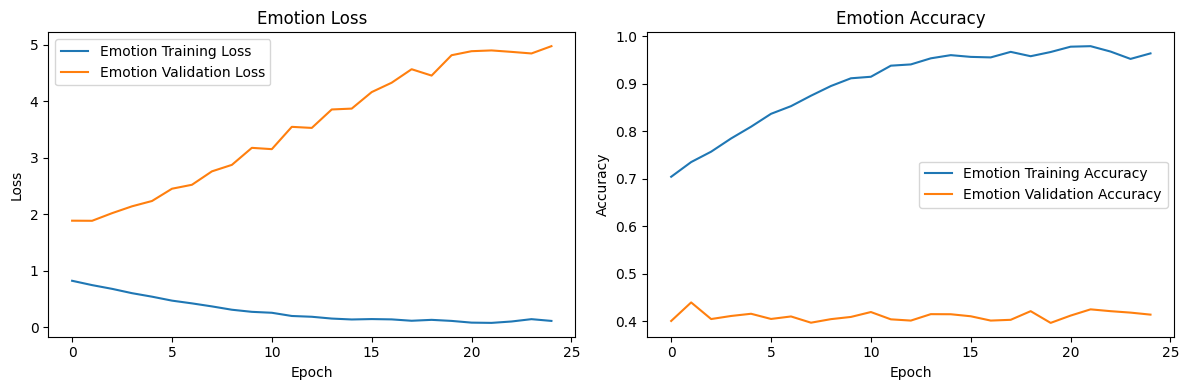

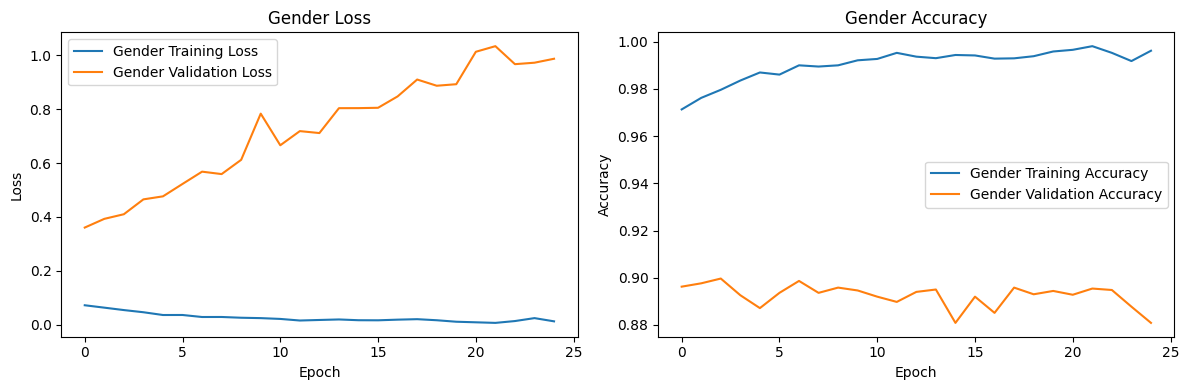

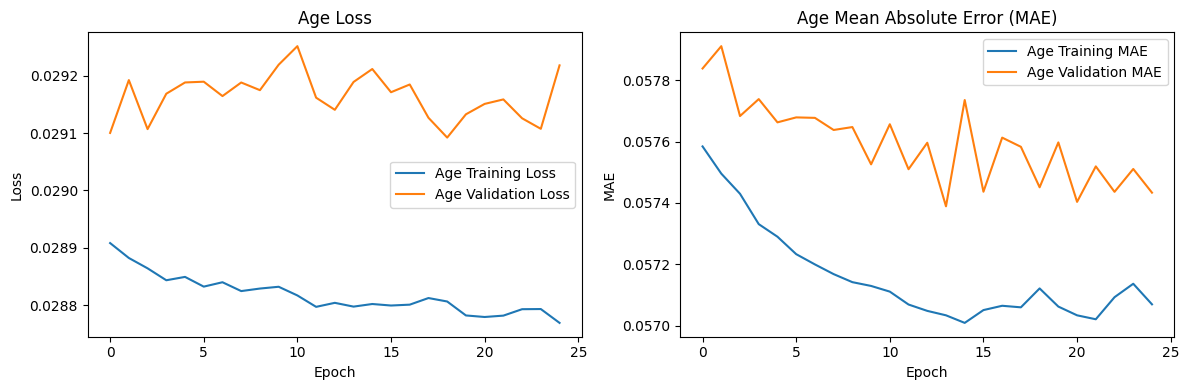

In [25]:
import matplotlib.pyplot as plt

# Plot training history for emotion
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_multi_output.history['emotion_output_loss'], label='Emotion Training Loss')
plt.plot(history_multi_output.history['val_emotion_output_loss'], label='Emotion Validation Loss')
plt.title('Emotion Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_multi_output.history['emotion_output_accuracy'], label='Emotion Training Accuracy')
plt.plot(history_multi_output.history['val_emotion_output_accuracy'], label='Emotion Validation Accuracy')
plt.title('Emotion Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Plot training history for gender
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_multi_output.history['gender_output_loss'], label='Gender Training Loss')
plt.plot(history_multi_output.history['val_gender_output_loss'], label='Gender Validation Loss')
plt.title('Gender Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_multi_output.history['gender_output_accuracy'], label='Gender Training Accuracy')
plt.plot(history_multi_output.history['val_gender_output_accuracy'], label='Gender Validation Accuracy')
plt.title('Gender Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Plot training history for age
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_multi_output.history['age_output_loss'], label='Age Training Loss')
plt.plot(history_multi_output.history['val_age_output_loss'], label='Age Validation Loss')
plt.title('Age Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_multi_output.history['age_output_mae'], label='Age Training MAE')
plt.plot(history_multi_output.history['val_age_output_mae'], label='Age Validation MAE')
plt.title('Age Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
# Save the multi-output model
model_multi_output.save('/content/drive/MyDrive/multi_output_model.h5')

print("Model saved successfully.")

Model saved successfully.
